### Retrieval Scoring + ranking


In [1]:
## Init stuff
import os
import json
import psycopg2
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()  # reads .env if present

REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT = os.getenv("REDDIT_USER_AGENT") or "knowledge-collection-service/0.1"

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- connect to Postgres ---
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="knowledgebase",
    user="stiw_user",
    password="stiw_pwd"
)
cursor = conn.cursor()
print("✅ Connected to Postgres and OpenAI")

✅ Connected to Postgres and OpenAI


Run once for Query & Query Embed, & test other systems for tweaks


In [2]:
user_input = input("Enter your query or goal: ").strip()
print(f"Query: --> {user_input}")

# Running HyDE style query improvement 

HyDE_prompt = f"""
You are an extremely empathetic Reddit user writing a raw, honest submission asking for help.
Write a detailed (150–250 word) Reddit post (title + body) from someone in exactly the same situation as the user below.
Make it the kind of thoughtful, non-ranty, "I know I need to change, please help me" post that gets tons of supportive, practical, life-changing advice in the comments.

Query / situation: {user_input}

Start directly with the post (include a realistic title and then the body). 
Do NOT write advice or a success story — only the help-seeking post.
"""

print("Creating a HyDE hypothetical Reddit submission (OP post)...")
HyDE_response = client.chat.completions.create(
    model="gpt-4o-mini",       
    messages=[
        {"role": "system", "content": "You are a Reddit user asking for help in a detailed, vulnerable way."},
        {"role": "user", "content": HyDE_prompt}
    ],
    temperature=0.8, # keeps it varied and natural
    max_tokens=500 # Wanna limit token usage here to create precise embeddings
)

HyDE_answer = HyDE_response.choices[0].message.content.strip()

print("\📄 HyDE generated hypothetical Reddit submission \n")
print(HyDE_answer)

# Embedd HyDE, query
q_emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=HyDE_answer
    ).data[0].embedding
print("✅ Query Embedding generated...")

Query: --> Hey I wanted to get fit
Creating a HyDE hypothetical Reddit submission (OP post)...
\📄 HyDE generated hypothetical Reddit submission 

**Title: Struggling to Get Fit and Make Lasting Changes – Need Your Support and Guidance**

Hello, Reddit community.

I'm reaching out because I find myself at a crossroads and desperately need your advice and encouragement. For a long time, I’ve noticed how out of shape I’ve become, both physically and mentally. I’m tired of feeling lethargic and unhealthy, and I truly want to get fit, but I feel completely lost on where to start.

I’ve tried different diets and workout routines in the past, but I often lose motivation and fall back into old habits. I know that I need to change, but I don’t want to set myself up for failure again. I believe it’s time to focus on making sustainable lifestyle changes, but I’m unsure how to approach this without overwhelming myself.

I could really use your insights on how to start small and build a routine tha

In [3]:
print(q_emb)

[0.02884126827120781, -0.014604776166379452, -0.007020420394837856, 0.04433222860097885, -9.65667495620437e-05, 0.0017435962799936533, 0.003783546155318618, 0.02909446321427822, -0.0011516079539433122, 0.04628873988986015, 0.020911645144224167, 0.0009523603366687894, -0.0269307941198349, -0.01165850181132555, 0.015686610713601112, 0.02274155803024769, 0.020992208272218704, 0.020531851798295975, 0.0012681353837251663, 0.047784894704818726, 0.060260526835918427, -0.02601008303463459, 0.04097163304686546, -0.006278097163885832, 0.004252533428370953, -0.03273127228021622, 0.024721087887883186, -0.00016211344336625189, 0.0014012068277224898, -0.012268472462892532, -0.023961501196026802, -0.01251015905290842, -0.0735647976398468, 0.0018558078445494175, 0.036943525075912476, -0.011641237884759903, -0.029577836394309998, -0.010714773088693619, 0.05248051881790161, -0.008234607987105846, 0.039843764156103134, -0.034779854118824005, 0.09676671028137207, 0.020013952627778053, -0.05068513378500938

Running through retrieved chunks for new scoring


In [4]:
print("Retrieveing top matching submissions....")
cursor.execute("""
            SELECT 
                submission_id,
                domain_id,
                title, 
                selftext, 
                permalink, 
                (embedding <=> %s::vector) AS distance
            FROM submissions
            ORDER BY embedding <=> %s::vector
            LIMIT 15;
        """, (json.dumps(q_emb), json.dumps(q_emb)))
top_subs = cursor.fetchall()
top_subs = [subs for subs in top_subs if subs[5] < 0.45]
if not top_subs:
    print("❌ No Relevant submissions found")
else:
    print(f"✅ Found {len(top_subs)} relevant submissions")

# Printing submissions
print(json.dumps(top_subs, indent=5))

Retrieveing top matching submissions....
✅ Found 13 relevant submissions
[
     [
          "juou3v",
          "ad0ac9aa-f840-4256-ba16-3c4190951655",
          "[META] Please stop telling yourself \u201cit will all change tomorrow\u201d because it won\u2019t and you know it",
          "It won\u2019t. You know it won\u2019t. \n\nYou\u2019re not just going to wake up as a productive supersoldier.\n\nYou have to start implementing seemingly small changes today, and building on them every day or every week. \n\nOur bodies and minds don\u2019t like dramatic change of any kind, so you need to take small steps in the right direction.\n\nGet up 15 minutes earlier than usual, not 3 hours.\n\nHave warm showers then turn them cold for the last quarter, so you don\u2019t just end up avoiding showers or having extremely short ones because that\u2019s just unhygienic. \n\nTry to workout one day per week more than you\u2019re currently doing, not daily. \n\nStart surfing the internet a little less

In [5]:
# Collect related comments
context_blocks = []
sources = []  # track all permalinks for final output

top_submission_ids = [row[0] for row in top_subs]
print(top_submission_ids)


# Pulling in the most Relevant comments from only the top posts that we get
# There is also a small scoring boost for the high upvoted comments, at the time of querying
# Relevance first tho, only then popularity
query = """
WITH ranked_comments AS (
    SELECT 
        c.body,
        c.score,
        s.title,
        c.submission_id,
        s.permalink,
        c.embedding <=> %s::vector AS distance
    FROM comments c
    JOIN submissions s ON c.submission_id = s.submission_id
    WHERE c.submission_id = ANY(%s)
)
SELECT 
    body,
    score,
    title,
    submission_id,
    permalink,
    distance
FROM ranked_comments
ORDER BY 
    distance + (1.0 / (score + 10)) ASC 
LIMIT 20;
"""

# Note the order of parameters is now --> embedding, submission_ids list
cursor.execute(query, (json.dumps(q_emb), top_submission_ids))
relevant_comments = cursor.fetchall()

print(f"\n✅ Retrieved {len(relevant_comments)} relevant comments\n")

# for i, (body, score, title, permalink, distance) in enumerate(relevant_comments, 1):
#     print(f"{i:2d}. ↑{score}  (dist: {distance:.4f}) | {title}")
#     print(f"     {body.strip()[:900]}{'...' if len(body) > 900 else ''}")
#     print(f"     https://reddit.com{permalink}\n")
# print("="*120)

# Context map contains : submission_id -> {submission_info, comments}
context_map = {}

# building submission details
submission_details = {}
for sub in top_subs:
    submission_id = sub[0]
    title = sub[2]
    selftext = sub[3]
    permalink = sub[4]
    
    submission_details[submission_id] = {
        'title': title,
        'selftext': selftext,
        'permalink': permalink
    }


for comment in relevant_comments:
    body = comment[0]
    score = comment[1]
    title = comment[2]
    submission_id = comment[3]
    permalink = comment[4]
    distance = comment[5]
    
    if submission_id not in context_map:
        # Get selftext from submission_details
        sub_info = submission_details.get(submission_id, {})
        
        context_map[submission_id] = {
            'title': title,
            'permalink': permalink,
            'selftext': sub_info.get('selftext', ''),
            'comments': []
        }
    
    context_map[submission_id]['comments'].append({
        'body': body,
        'score': score,
        'distance': distance
    })

print(f"✅ Built context map with {len(context_map)} submissions\n")
print(json.dumps(context_map, indent=5))

['juou3v', 'dl265l', '9hjn8y', '8ogzss', '93kcov', 'lw0bsm', '8hht7o', '1jvm5jj', '9t0gqz', 'z9q8hm', '1kc67ha', '631os1', 'fzz5mi']

✅ Retrieved 20 relevant comments

✅ Built context map with 8 submissions

{
     "8hht7o": {
          "title": "Progress\u2014 size 14 to size 4, 197 pounds to 130",
          "permalink": "https://www.reddit.com/r/xxfitness/comments/8hht7o/progress_size_14_to_size_4_197_pounds_to_130/",
          "selftext": "https://imgur.com/gallery/WgXZwEl\n\nI hope I did this right! \n\nStarting weight was 197, size 14. 5\u20193 for reference. \n\nI didn\u2019t diet at all. I made significant lifestyle changes. \n\nI ate fast food once a day at my peak weight, plus multiple sodas. I was very sedentary. \n\nI started slow. I cut out soda except for one a week, and stuck to the perimeter of the grocery store when shopping. I cut out almost all processed food. If I didn\u2019t prepare it myself, it wasn\u2019t eaten. This part was surprisingly easy at first. I was mot

# Looking at more fetched comment details


In [6]:
# Prepare for generation, 
context_blocks = []
sources = []

for submission_id, data in context_map.items():
    title = data['title']
    permalink = data['permalink']
    selftext = data['selftext']
    comments = data['comments']
    
    # Format comments
    joined_comments = "\n".join([
        f"- (↑{c['score']}) {c['body'][:600]}..." 
        for c in comments
    ])
    
    # Build block
    block = f"""
[POST] "{title}"
URL: {permalink}

{selftext[:1200] if selftext else "(No text body)"}

Top Comments:
{joined_comments}
"""
    context_blocks.append(block)
    sources.append(f"- {title}: {permalink}")

# Final context text to pass to LLM
context_text = "\n\n---\n\n".join(context_blocks)

print("CONTEXT FOR LLM:")
print(context_text)
print("\n" )
print("SOURCES:")
print("\n".join(sources))

CONTEXT FOR LLM:

[POST] "Progress— size 14 to size 4, 197 pounds to 130"
URL: https://www.reddit.com/r/xxfitness/comments/8hht7o/progress_size_14_to_size_4_197_pounds_to_130/

https://imgur.com/gallery/WgXZwEl

I hope I did this right! 

Starting weight was 197, size 14. 5’3 for reference. 

I didn’t diet at all. I made significant lifestyle changes. 

I ate fast food once a day at my peak weight, plus multiple sodas. I was very sedentary. 

I started slow. I cut out soda except for one a week, and stuck to the perimeter of the grocery store when shopping. I cut out almost all processed food. If I didn’t prepare it myself, it wasn’t eaten. This part was surprisingly easy at first. I was motivated. When I looked at it as getting healthier rather than getting thinner, it made a huge difference. Mentality matters, ladies!!! I started couch to 5k at this point too. That was harder. I was so embarrassed at how hard it was to run. I got a used treadmill on Craigslist and used it because I d

### Step Extraction + K-Clustering


In [7]:
all_steps = []
action_step_prompt = """
Extract actionable steps the user could take that are either:
• explicitly stated OR
• strongly implied by the comment

You may rewrite the steps in your own words BUT:
- Do NOT invent new ideas
- Do NOT give generic advice unrelated to the comment
- Keep each step specific and short (max 15 words)

Return ONLY:
{"steps": ["step 1", "step 2", ...]}

COMMENT:
"""

for sub_id, sub_data in context_map.items():
    print(f"\nDeriving Actionable steps for Submission -> {sub_data['title']} [{sub_id}]")

    for c in sub_data['comments']:
        comment_body = c["body"]
        score = c["score"]

        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Extract only actionable steps, implied or explicit."},
                {"role": "user", "content": action_step_prompt + comment_body}
            ],
            temperature=0.1,
            max_tokens=150
        )

        raw = resp.choices[0].message.content
        print("RAW:\n", raw)

        try:
            # Strip markdown code blocks if present
            cleaned = raw.strip()
            if cleaned.startswith("```"):
                # Remove opening ```json or ```
                cleaned = cleaned.split('\n', 1)[1] if '\n' in cleaned else cleaned
                # Remove closing ```
                if cleaned.endswith("```"):
                    cleaned = cleaned.rsplit("```", 1)[0]
            
            cleaned = cleaned.strip()
            parsed = json.loads(cleaned)
            steps = parsed.get("steps", [])
        except Exception as e:
            print("JSON error:", e)
            steps = []
        
        for step_text in steps:
            emb = client.embeddings.create(
                model="text-embedding-3-small",
                input=step_text
            ).data[0].embedding

            all_steps.append({
                "step": step_text,
                "embedding": emb,
                "submission_id": sub_id,
                "permalink": sub_data['permalink'],
                "score": score
            })

print(f"TOTAL extracted steps: {len(all_steps)}")
for s in all_steps[:10]:
    print("•", s["step"])


Deriving Actionable steps for Submission -> Progress— size 14 to size 4, 197 pounds to 130 [8hht7o]
RAW:
 {"steps": ["Continue walking 2 miles 4 times a week.", "Track food intake consistently.", "Learn about calories and nutrition.", "Engage with the community for support."]}
RAW:
 {"steps": ["Continue focusing on mental health and positive outlook.", "Celebrate non-scale victories in your journey.", "Engage with supportive communities like CrossFit."]}
RAW:
 {"steps": ["Start the C25K program this week.", "Reflect on mental adjustments during your journey.", "Be kinder to yourself mentally."]}
RAW:
 {"steps": ["Focus on living a long, healthy, and happy life.", "Prioritize both health and happiness in your goals."]}

Deriving Actionable steps for Submission -> Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs) [9hjn8y]
RAW:
 {"steps": ["Sign up for the gym tomorrow.", "Focus on improving your diet.", "Set a goal to achieve a 6-pack."]}
RAW:
 {"steps"

Clusterning these for creating next action step summaries


In [8]:
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Convert to matrix of embeddings
X = np.array([s["embedding"] for s in all_steps])

# Use cosine distance instead of Euclidean
clusterer = HDBSCAN(
    metric="euclidean",
    min_cluster_size=4,
    min_samples=2,
    cluster_selection_epsilon=0.05
)

labels = clusterer.fit_predict(X)

# Attach cluster id to steps
for i, s in enumerate(all_steps):
    s["cluster"] = int(labels[i])

# Filter out noise (-1)
clusters = {}
for s in all_steps:
    cid = s["cluster"]
    if cid == -1:
        continue
    clusters.setdefault(cid, []).append(s)

print(f"🧩 Number of clusters: {len(clusters)}")
for cid, steps in clusters.items():
    print(f"\nCluster {cid} — {len(steps)} steps:")
    for s in steps[:5]:
        print("  •", s["step"])


🧩 Number of clusters: 8

Cluster 3 — 6 steps:
  • Engage with the community for support.
  • Engage with supportive communities like CrossFit.
  • Join supportive communities for encouragement.
  • Seek supportive environments at the gym and from healthcare providers.
  • Consider joining a lifting community for support.

Cluster 4 — 8 steps:
  • Continue focusing on mental health and positive outlook.
  • Focus on living a long, healthy, and happy life.
  • Ignore negative comments from others.
  • Focus on self-acceptance and ignore negativity from others.
  • Focus on the positive changes running brings.

Cluster 1 — 4 steps:
  • Start the C25K program this week.
  • Incorporate more physical activity into your routine.
  • Commit to regular running sessions.
  • Incorporate running and cooking into your routine.

Cluster 5 — 4 steps:
  • Reflect on mental adjustments during your journey.
  • Reflect on past experiences with food and body image.
  • Reflect on your mental health cha

c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\sklearn\cluster\_hdbscan\hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(


Cluster visualization


c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


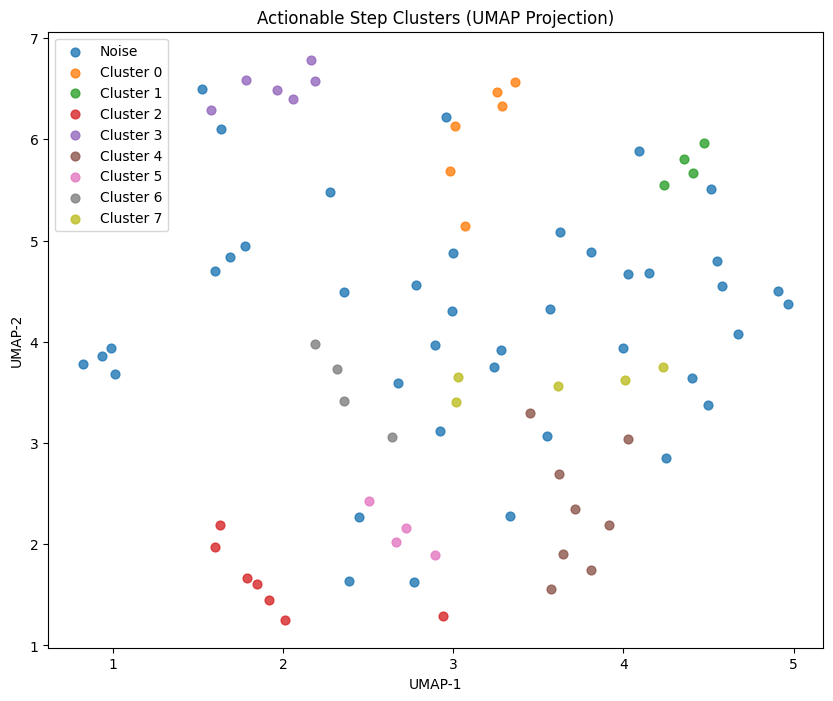

In [9]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Extract embeddings + cluster labels
X = np.array([s["embedding"] for s in all_steps])
labels = np.array([s["cluster"] for s in all_steps])
steps_text = [s["step"] for s in all_steps]

# Project to 2D using UMAP (recommended for embeddings)
reducer = umap.UMAP(
    n_neighbors=12,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding_2d = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))
unique_labels = sorted(set(labels))

for lab in unique_labels:
    mask = labels == lab
    label_name = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        s=40,
        alpha=0.8,
        label=label_name
    )

plt.legend()
plt.title("Actionable Step Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [10]:
from scipy.spatial.distance import cosine

final_steps = []

for cid, items in clusters.items():
    combined_text = "\n".join([i["step"] for i in items])

    # Summarize cluster
    summary_resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Summarize similar steps into one clean actionable step."},
            {"role": "user", "content": f"Combine these into one step:\n{combined_text}"}
        ],
        temperature=0.2,
        max_tokens=80
    )

    summary = summary_resp.choices[0].message.content.strip()

    # Compute cluster relevance to query
    q = np.array(q_emb)
    rel_scores = []
    for i in items:
        emb = np.array(i["embedding"])
        rel = 1 - cosine(emb, q)
        rel_scores.append(float(rel))

    final_steps.append({
        "cluster_id": cid,
        "action_step": summary,
        "frequency": len(items),
        "avg_relevance": float(np.mean(rel_scores)),
        "sources": [
            {
                "submission_id": i["submission_id"],
                "url": i["permalink"],
                "score": i["score"],
                "relevance": float(1 - cosine(np.array(i["embedding"]), q)),
                "original_step": i["step"],
                "step_embedding": i["embedding"]
            }
            for i in items
        ]
    })

# Sort higher frequency + higher relevance first
final_steps.sort(
    key=lambda x: (x["frequency"], x["avg_relevance"]),
    reverse=True
)

In [11]:
print(json.dumps(final_steps, indent=5))

[
     {
          "cluster_id": 4,
          "action_step": "Prioritize a positive mindset by embracing self-acceptance, focusing on mental and physical well-being, and disregarding negativity from both internal and external sources.",
          "frequency": 8,
          "avg_relevance": 0.26629070876435734,
          "sources": [
               {
                    "submission_id": "8hht7o",
                    "url": "https://www.reddit.com/r/xxfitness/comments/8hht7o/progress_size_14_to_size_4_197_pounds_to_130/",
                    "score": 41,
                    "relevance": 0.29091650724799933,
                    "original_step": "Continue focusing on mental health and positive outlook.",
                    "step_embedding": [
                         0.03547099605202675,
                         0.0017589186318218708,
                         0.019682075828313828,
                         0.07786315679550171,
                         -0.03620891273021698,
                 

In [12]:
for cluster in final_steps:
    # Advice based scoring
    src_scores = [s["score"] for s in cluster["sources"]]
    cluster_value = np.mean(src_scores)/ np.max(src_scores)
    cluster['cluster_value'] = cluster_value

print(len(final_steps))

print(json.dumps(final_steps, indent=5))

filtered_clusters = [cluster for cluster in final_steps if cluster['cluster_value'] > 0.20]
print(len(filtered_clusters))

8
[
     {
          "cluster_id": 4,
          "action_step": "Prioritize a positive mindset by embracing self-acceptance, focusing on mental and physical well-being, and disregarding negativity from both internal and external sources.",
          "frequency": 8,
          "avg_relevance": 0.26629070876435734,
          "sources": [
               {
                    "submission_id": "8hht7o",
                    "url": "https://www.reddit.com/r/xxfitness/comments/8hht7o/progress_size_14_to_size_4_197_pounds_to_130/",
                    "score": 41,
                    "relevance": 0.29091650724799933,
                    "original_step": "Continue focusing on mental health and positive outlook.",
                    "step_embedding": [
                         0.03547099605202675,
                         0.0017589186318218708,
                         0.019682075828313828,
                         0.07786315679550171,
                         -0.03620891273021698,
               

In [13]:
# import json

# # How many clusters you filtered out earlier

# # Convert final_steps list to JSON (LLM-friendly)
# final_steps_json = json.dumps(final_steps, indent=2)

# final_prompt = f"""
# You are producing distilled, high-confidence actionable steps based on crowdsourced insights.

# Here is the processed dataset of clusters, each containing:
# - action_step (summary of similar steps)
# - frequency (how many people said it)
# - avg_relevance (semantic relevance to the user’s question)
# - usefulness (normalized Reddit score)
# - cluster_id
# - sources

# Your job:
# 1. Present the final actionable steps in a ranked list (most supported + most relevant first).
# 2. For each step, show:
#    - The actionable step
#    - How many people independently mentioned it (frequency)
#    - Why it’s relevant
# 3. Write in a clean, motivational, practical tone. No fluff. Just clarity.

# Here is the input data:
# {final_steps_json}
# """

# # Call OpenAI
# resp = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "system", "content": "You are a concise, structured advisor."},
#         {"role": "user", "content": final_prompt}
#     ],
#     temperature=0.3,
#     max_tokens=800
# )

# final_output = resp.choices[0].message.content

# print(final_output)


Selecting the best representative from each cluster


In [14]:
from scipy.spatial.distance import cosine
import numpy as np

action_steps = []

for cluster in filtered_clusters:
    
    # Extract step embeddings safely
    step_embeds = np.array(
        [np.array(source['step_embedding'], dtype=float) for source in cluster['sources']]
    )
    
    # Compute centroid of the cluster
    centroid = np.mean(step_embeds, axis=0)

    # Compute cosine DISTANCES to centroid
    distances = [cosine(e, centroid) for e in step_embeds]

    # Best representative = minimum distance to centroid
    best_index = int(np.argmin(distances))

    best_source = cluster['sources'][best_index]
    # Usefullness scores
    """
    A usefull score must tie : 
        --> How relevant it is to the query,
        --> How it represents the clusters, idea
        --> Crowd source or cluster relevance 
    """

    relevance = best_source["relevance"]
    centroid_sim = 1 - cosine(best_source["step_embedding"], centroid)
    cluster_value = cluster["cluster_value"]  

    usefulness = 0.5 * relevance + 0.3 * centroid_sim + 0.2 * cluster_value
 
    action_steps.append({
        "url": best_source['url'],
        "step": best_source['original_step'],
        "usefulness": usefulness
    })


In [15]:
ranked_action_steps = sorted(action_steps, key=lambda x : x['usefulness'], reverse=True)
print("Next Recommended Steps")
for step in ranked_action_steps:
    print(f"{step['step']}, {int(step['usefulness'] * 100)} % found this usefull")

Next Recommended Steps
Join supportive communities for encouragement., 58 % found this usefull
Reflect on your mental health challenges and habits., 57 % found this usefull
Incorporate running and cooking into your routine., 56 % found this usefull
Focus on improving your diet., 54 % found this usefull
Give the gym a real chance., 52 % found this usefull
Be mindful of your progression and self-improvement., 48 % found this usefull
Acknowledge the difficulty of accepting your reality., 43 % found this usefull
